In [145]:
import numpy as np
import matplotlib.pyplot as plt
import iop_ext as iop
import lf14 as lf
import math

In [146]:
#assigning constants

#use NEA & use constants regarding a singular exoplanet
au=1.49598e11 #meters - astronomical unit(dist. from Earth to Sun)
L_sun=3.828e26 #Watts - luminosity of our star
M_sun=1.989e30 #Kg - mass of our star
M_ea=5.97219e24 #Kg - mass of earth
R_ea=6.371e6 #meters - radius of earth
L_star=0.5*L_sun #placeholder 
M_star=0.665*M_sun
Teq=871 # Equilibrium temperature in Kelvin
a= 0.0422*au #semimajor axis
a_0 = 0.5 ##slope at which L_He decreases over time
yr=3600*24*365 #Converting year to seconds
t_sat=1e8*yr #100 million years to seconds
cmf_p=0.325 #reduced core mass fraction
G=6.67e-11 #Universal Gravitational Constant
L_sat=(10**-3.5)*L_sun*(M_star/M_sun) #Saturation Luminosity
pi=math.pi
x0=0.5 #initial water mass fraction
Gyr=1e9 #billion years



In [147]:
#initalizing variables
t=1e6*yr #1 million years to seconds
#Range from 1-20

In [148]:
#functions
#Mp will range from 0-20 in terms of Earth masses

#FOR RADIUS, USE IOP & ERROR IOP
def wmfraction(Mp,Mp0,X0):
    return(1-((Mp0-(X0*Mp0))/Mp))
def Rp_function(CMF,X,Teq,Mp): #Mp in kg, returns Rp in meters
    Mp_e=Mp/M_ea
    Rp_e=iop.radius_iop(CMF,X,Teq,Mp_e)
    return(Rp_e*R_ea)#X is water mass fraction, function not made yet
#High energy luminosity
def L_He_function(M_star,t): #t in Myr
    if t<t_sat:
        return(L_sat)
    else:
        return((L_sat)*((t/t_sat)**(-1-a_0)))
#Efficiency parameter η - how much HE is converted into mass loss
def eff_par(Mp,Rp):
    v_esc=((2*(G)*Mp)/(Rp))**(0.5)
    return(0.1*(((v_esc)/(15000))**(-2)))
#Mass-loss rate
def ml_rate(Mp,Rp,a,t): #In earth masses/Billion Years
    L_HiE=L_He_function(M_star,t)
    e_p=eff_par(Mp,Rp)
    return(1*(e_p*((Rp**3)*L_HiE)/(4*(a**2)*(G)*Mp))) #given in kg/s

    

In [149]:
Rp=Rp_function(0.325,0,300,1)
print(Rp)

2876947.206561057


In [150]:
#function testing
print(wmfraction(0.66*M_ea,1*M_ea,x0))
print(L_He_function(M_sun,1e9*yr))
print(eff_par(M_ea,R_ea))
print(ml_rate(M_ea,R_ea,a,t)*(1e9*yr)/M_ea)   #Earth masses per Gyr
print(ml_rate(M_ea,R_ea,a,t)) #kg/s

0.24242424242424243
2.5456200000000004e+21
0.179928797562911
0.3114541630847878
58982224.70298512


In [161]:
#Evolution
t_evo=(1e6*yr)/10 #time
del_t=1e6*yr #increment of time changing per 1 million years
tmax=10e9*yr #placeholder, to prevent computer overload
Mp_0=4.53*M_ea #original mass of planet
X_0=0.5 #original WMF
Rp_evo=1.704*R_ea #radius of the planet that will change over time
Mp_evo=4.53*M_ea #mass of the planet that will change over time
X_evo=0.5 #WMF that will change over time
ml=ml_rate(Mp_evo,Rp_evo,a,t_evo)
error_code=iop.error_iop(cmf_p,X_evo,Teq,Mp_evo/M_ea)

#CREATING TIMESTEPS
time_checkpoint = 0
checkpoint_limit = (1e6*yr) * 10 #number of points between each save
Rp_evo=Rp_function(cmf_p,X_evo,Teq,Mp_evo)
#saving arrays

time_array = np.array([])
mp_array = np.array([])
rp_array = np.array([])
X_array = np.array([])
error_array = np.array([])
ml_array=np.array([])

time_array = np.append(time_array, t_evo) #seconds
mp_array = np.append(mp_array, Mp_evo) #kg
rp_array = np.append(rp_array, Rp_evo) #m
X_array = np.append(X_array, X_evo) #Water mass fraction
error_array = np.append(error_array, error_code) #In case of error with radius in IOP
ml_array=np.append(ml_array,ml)

while t_evo<tmax: 
    M_multi=((ml*del_t))
    Mp_evo=(Mp_evo-M_multi)
    X_evo=wmfraction(Mp_evo,Mp_0,x0)
    Rp_evo=(Rp_function(cmf_p,X_evo,Teq,Mp_evo))
    error_code=iop.error_iop(cmf_p,X_evo,Teq,Mp_evo/M_ea)
    t_evo=t_evo+del_t #increasing time
    
    if X_evo<=0:
        print("negative wmf")
        break
    elif Rp_evo<0:
        print("negative radius")
        break
    elif ml<0:
        print("Negative ml rate")
        break
    elif error_code==2:
        print("error code = 2")
        break
    
    ml=ml_rate(Mp_evo,Rp_evo,a,t_evo)
    time_checkpoint = time_checkpoint + del_t

    if time_checkpoint > checkpoint_limit:
        time_array = np.append(time_array, t_evo) #seconds
        mp_array = np.append(mp_array, Mp_evo) #kg
        rp_array = np.append(rp_array, Rp_evo) #m
        X_array = np.append(X_array, X_evo) 
        error_array = np.append(error_array, error_code)
        ml_array=np.append(ml_array,ml)
        time_checkpoint = 0

time_array = np.append(time_array, t_evo) #seconds
mp_array = np.append(mp_array, Mp_evo) #kg
rp_array = np.append(rp_array, Rp_evo) #m
X_array = np.append(X_array, X_evo) #water mass fractiom
error_array = np.append(error_array, error_code) #in case of error in IOP
ml_array=np.append(ml_array,ml)
        

        

In [152]:
mp_array1=mp_array
time_array1=time_array

In [162]:
np.savetxt("./data/evolution_TOI-836b_AC.dat", np.c_[time_array, mp_array, rp_array, X_array, error_array,ml_array], fmt='%.12f')


In [76]:
#deltat should be 1 million years

In [133]:
#testing
#print(time_array)
#print(mp_array/M_ea)
#print(rp_array)
#print(X_array)
#print(error_array)

In [163]:
#IMPORTING EVOLUTION DATA
age,list_planetevo_m, list_planetevo_r, water_mass_fraction, error, ml = np.loadtxt("./data/evolution_TOI-836b_AC.dat", unpack=True, usecols=(0,1,2,3,4,5))

print("planet evolution successfully imported")

planet evolution successfully imported


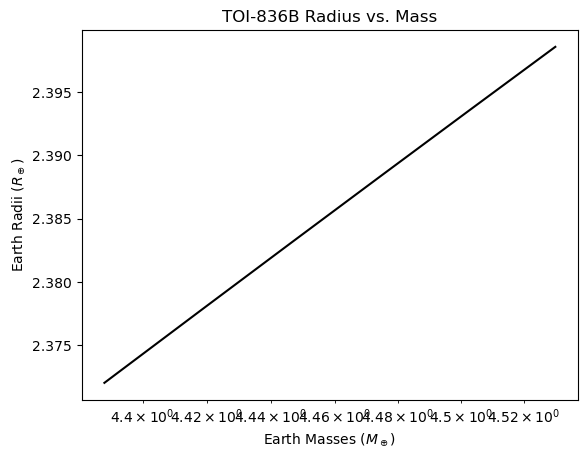

In [137]:
plt.plot((list_planetevo_m/M_ea), (list_planetevo_r/R_ea), color="black", linestyle="-", label="Simulated Planet")
plt.xscale("log") 
plt.title("TOI-836B Radius vs. Mass")
plt.xlabel("Earth Masses ($M_\\oplus$)")
plt.ylabel("Earth Radii ($R_\\oplus$)")
plt.show()

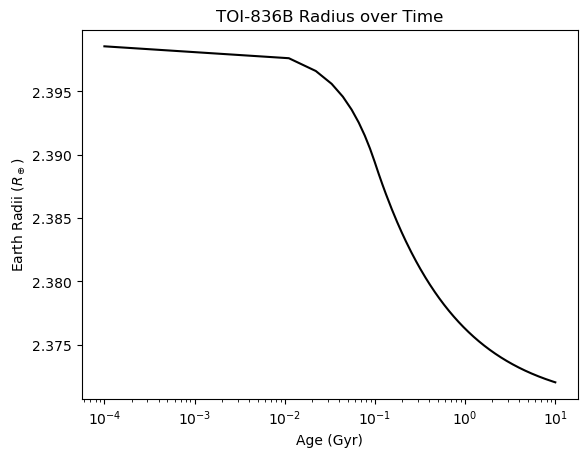

In [138]:
plt.plot(age/(Gyr*yr), (list_planetevo_r/R_ea), color="black", linestyle="-", label="Simulated Planet")
plt.xscale("log") 
plt.title("TOI-836B Radius over Time")
plt.xlabel("Age (Gyr)")
plt.ylabel("Earth Radii ($R_\\oplus$)")
plt.show()

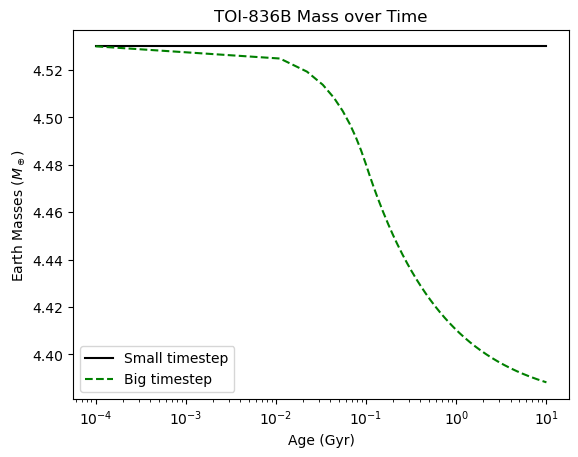

In [139]:
plt.plot(time_array1/(Gyr*yr), (mp_array1/M_ea), color="black", linestyle="-", label="Small timestep")
plt.plot(time_array/(Gyr*yr), (mp_array/M_ea), color="green", linestyle="--", label="Big timestep")
plt.xscale("log") 
plt.title("TOI-836B Mass over Time")
plt.xlabel("Age (Gyr)")
plt.ylabel("Earth Masses ($M_\\oplus$)")
plt.legend()
plt.show()

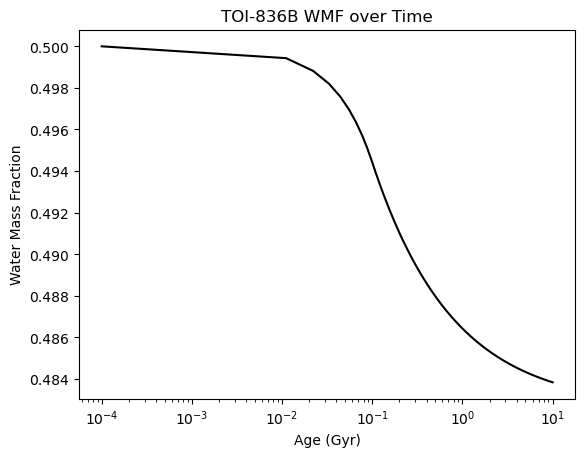

In [140]:
plt.plot(age/(Gyr*yr), (water_mass_fraction), color="black", linestyle="-", label="Simulated Planet")
plt.xscale("log") 
plt.title("TOI-836B WMF over Time")
plt.xlabel("Age (Gyr)")
plt.ylabel("Water Mass Fraction")
plt.show()

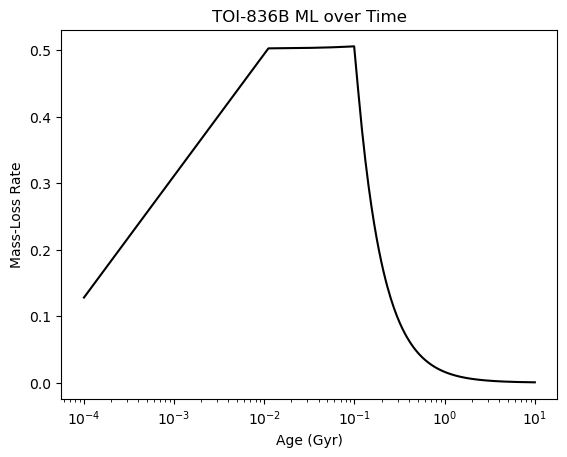

In [164]:
plt.plot(age/(Gyr*yr), (ml_array*(Gyr*yr)/M_ea), color="black", linestyle="-", label="Simulated Planet")
plt.xscale("log") 
plt.title("TOI-836B ML over Time")
plt.xlabel("Age (Gyr)")
plt.ylabel("Mass-Loss Rate")
plt.show()